Now that the neural network is built, able to have data passed through it, and capable of
calculating loss, the next step is to determine how to adjust the weights and biases to decrease the
loss. Finding an intelligent way to adjust the neurons’ input’s weights and biases to minimize loss
is the main difficulty of neural networks.

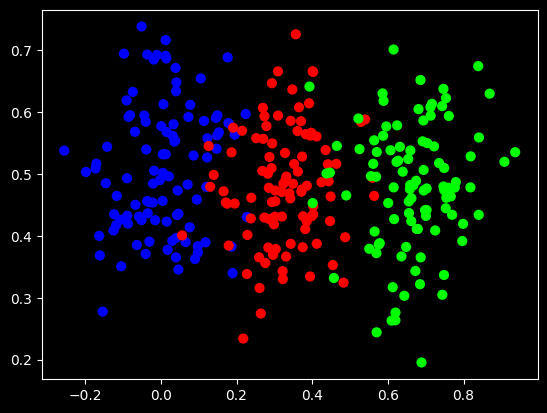

In [5]:
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import vertical_data

nnfs.init()

X, y = vertical_data(samples=100, classes=3)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

### Using the previously created code up to this point, we can use this new dataset with a simple neural network:

In [8]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data, vertical_data   # type: ignore
import nnfs # type: ignore

nnfs.init()

# Dense Layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward Pass
    def forward(self, inputs):
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases


class ReLU:
    
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

class Softmax:

    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

# Common loss class
class Loss:

    # Calculate the data and regularization losses given model output and ground truth values
    def calculate(self, output, y):
         # Calculate sample losses
         sample_losses = self.forward(output, y)

         # Calculate mean loss
         data_loss = np.mean(sample_losses)

         return data_loss

# Cross-entropy loss
class Loss_CategoricalCrossEntropy(Loss):

    def forward(self, y_pred, y_true):
        
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values
        # Only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihood = -np.log(correct_confidences)
        return negative_log_likelihood
    
# Create dataset
X, y = spiral_data(samples = 100, classes = 3)

dense1 = Layer_Dense(2, 3)
activation1 = ReLU()

dense2 = Layer_Dense(3, 3)
activation2 = Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossEntropy()

# Then create some helper variables to track the best loss and the associated weights and biases
lowest_loss = float('+inf')
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()



We initialized the loss to a large value and will decrease it when a new, lower, loss is found. We
are also copying weights and biases (copy() ensures a full copy instead of a reference to the
object). Now we iterate as many times as desired, pick random values for weights and biases, and
save the weights and biases if they generate the lowest-seen loss:

In [9]:
for iteration in range(10000):
    # Generate a new set of weights for iteration
    dense1.weights = 0.05 * np.random.randn(2, 3)
    dense1.biases = 0.05 * np.random.randn(1, 3)
    dense2.weights = 0.05 * np.random.randn(3, 3)
    dense2.biases = 0.05 * np.random.randn(1, 3)

    # Perform a forward pass of the training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # Perform a forward pass through activation function
    # It takes the output of second dense layer here and returns loss
    loss = loss_function.calculate(activation2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # Calculate values along first axis
    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions==y)

    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print('New set of weights found, iteration:', iteration,
        'loss:', loss, 'acc:', accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss

New set of weights found, iteration: 0 loss: 1.1008568 acc: 0.3333333333333333
New set of weights found, iteration: 1 loss: 1.0990819 acc: 0.3333333333333333
New set of weights found, iteration: 3 loss: 1.0986291 acc: 0.3333333333333333
New set of weights found, iteration: 11 loss: 1.0985013 acc: 0.3333333333333333
New set of weights found, iteration: 58 loss: 1.0984759 acc: 0.36666666666666664
New set of weights found, iteration: 87 loss: 1.0984341 acc: 0.3933333333333333
New set of weights found, iteration: 389 loss: 1.0983855 acc: 0.3333333333333333
New set of weights found, iteration: 602 loss: 1.0983611 acc: 0.3433333333333333
New set of weights found, iteration: 812 loss: 1.0983338 acc: 0.3333333333333333
New set of weights found, iteration: 1765 loss: 1.0982677 acc: 0.37
New set of weights found, iteration: 3766 loss: 1.0980942 acc: 0.3333333333333333
New set of weights found, iteration: 3979 loss: 1.0980837 acc: 0.3333333333333333
New set of weights found, iteration: 5582 loss:

Loss certainly falls, though not by much. Accuracy did not improve, except for a singular
situation where the model randomly found a set of weights yielding better accuracy. Still, with a
fairly large loss, this state is not stable.


This doesn’t appear to be a reliable method
for minimizing loss.

This training session ended with almost no progress. Loss decreased slightly and accuracy is
barely above the initial value. Later, we’ll learn that the most probable reason for this is called a
local minimum of loss. The data complexity is also not irrelevant here. It turns out hard problems
are hard for a reason, and we need to approach this problem more intelligently.